# LSTM

Author: ZHANG Yu

The code is used to do calsssification of quickdraw dataset with 5 classes using LSTM. 

The model here can achieve 94.67%, 88.06%, 83.53% and 72.32% accuracy for complete dataset, 90% incomplete dataset, 70% incomplete dataset and 50% incomplete dataset respectively


### The simplified process is:
1. Get data
2. Preprocess data
3. Choose hyperparameters
4. Construct LSTM network
5. Train the network
6. Evaluate the network 

### To run the code:
1. Change path and parameters
2. Run the code

In [ ]:
import sys
import os
os.environ["CUDA VISIBLE_DEVICES"]="0"
import math
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.switch_backend('agg')
import tensorflow as tf
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, LSTM, Conv2D, Reshape
from keras.callbacks import LearningRateScheduler
import keras.backend as K
from sklearn.metrics import confusion_matrix
import utils_
from utils_ import get_dataset, find_max_strok_point, convert_to_zeropad, label_onehot, plot_history,data_visual


## Get data
200000 training data was selected, 80% of them was used for training the neural network, while the remaining 20% was used to validate network after each training.

All 126649 data in testset was used for testing the model.

test_r1=0.9 means using 90% data of complete dataset, whose stoke numbers are 90% of original data

In [2]:
data_path = '/raid5/liuchang/quick_draw_output' # change path here
data_name = '1102_05b633244'

train_X,train_Y,test_X,test_Y,test_X1,test_X2,test_X3=get_dataset(data_path,data_name,test_r1=0.9,test_r2=0.7,test_r3=0.5)




## Data visualization
From the pie chart below, it can be seen that we have relatively balance datasets for training, validation and testing

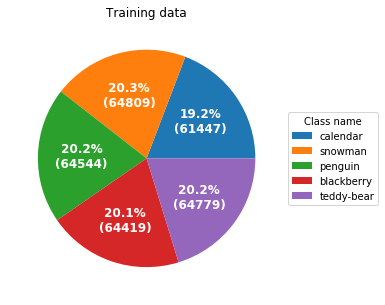

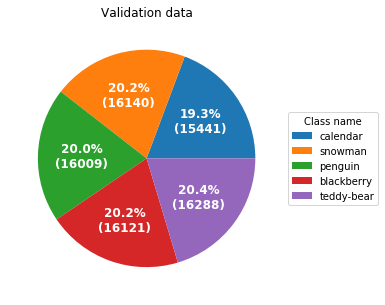

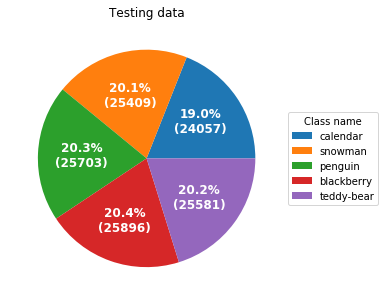

In [3]:
data_visual(train_Y[:320000],'Training data')
data_visual(train_Y[320000:],'Validation data')
data_visual(test_Y,'Testing data')

## Preprocess data
Zero padding both train data and test data to same length

Convert label to onehot form to fit 'mean_squared_error' loss function's requirement

### Normalize data
Make sure that mean over entire training data is zero. For testing data, subtract the mean vector of the training data rather than the mean of testing data. Since the mean of testing data at runtime was unknown

Normalization makes training less sensitive to the scale of features

Normalizing will ensure that a convergence problem does not have a massive variance, making optimization feasible, which accelarates the training process to some degree



In [4]:

max_stroke,max_point=find_max_strok_point(train_X,test_X)
train_data = convert_to_zeropad(train_X,max_stroke,max_point)
train_label = label_onehot(train_Y)
test_label = label_onehot(test_Y)
test_data = convert_to_zeropad(test_X,max_stroke,max_point)
test_data1 = convert_to_zeropad(test_X1,max_stroke,max_point)
test_data2 = convert_to_zeropad(test_X2,max_stroke,max_point)
test_data3 = convert_to_zeropad(test_X3,max_stroke,max_point)


max stroke number in train data = 30 
 max point number in train data = 200
training data number = 400000
max stroke number in test data = 30 
 max point number in test data = 200
test data number = 126649
done
done
done
done
done


In [5]:
mean= train_data.mean()
std= train_data.std()

train_data = (train_data - mean)/std
test_data = (test_data - mean)/std
test_data1 = (test_data1 - mean)/std
test_data2 = (test_data2 - mean)/std
test_data3 = (test_data3 - mean)/std


## Setting parameters
I use input size 2, which is [x,y] position information of a point, and seq_len=number of points in an image at first, but no matter how I change the parameters and structure of the network, the accuracy almost remian the same at around 30%. I use MINST dataset to check my network, it can achiave accuracy as high as 98.72%, so I am sure it is not my network's problem. Then it must be the problem of data precessing. Input size 2 is too small compared with the hidden size I choosed (or a common number of hidden size), and also the seq_len is too large, since lstm cannot learn very long dependencies (no more than 50 steps) as I noticed later. So I changed these two parameters as below and network began to work normally

Batch size:16-128 is a common option. Setting the minibatch size to a very small number may contribute to noisy score vs. iteration graphs, and might lead to optimization difficulties. Especially, for rnn, minibatch cannot be choosen casually. When I choose batch size=256, the network once gave the same output(loss=0.2, accuracy=0.19) after each epoch

I also met a problem that my Neural Network throwing NAN values.Backpropagation involves the multiplication of very small gradients, due to limited precision when representing real numbers values very close to zero can not be represented. To solve this, I retuned your network, e.g. reducing hidden size, very small gradients thus may be avoided and the problem is fixed

In [6]:
bs = 128 # batch size
seq_len = max_stroke 
input_size = 2*max_point 
hidden_size = 400
output_size = 5 # n calsses
EPOCH = 40 # train the training data n times


## Build lstm model
* Activation functions for the hidden units are needed to introduce nonlinearity into the network. tanh is a common used activation function in lstm, whose second derivative can sustain for a long range before going to zero thus overcoming the vanishing gradient problem, it is bounded to range (-1,1), the data has already been rescaled in utils_.convert_to_zeropad to meet the bounds of the functions.

* Dropout, a frequently used regularization method, can help reducing overfitting of training data

In [7]:
model = Sequential()
model.add(LSTM(hidden_size, activation='tanh', return_sequences=False, input_shape=(seq_len,input_size))) #bs*seq_len*input_size-->bs*seq_len*hidden_size
model.add(Dense(output_size, activation='linear', kernel_initializer='normal')) #bs*1*hidden_size-->bs*output_size, seq_len-->1 by selecting the last score in lstm
#model.add(Dropout(0.2))
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 400)               1281600   
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 2005      
Total params: 1,283,605
Trainable params: 1,283,605
Non-trainable params: 0
_________________________________________________________________


### Reducing learning rate by 0.9 every two epoch

In [8]:
def scheduler(epoch):
    if epoch%2==0 and epoch!=0:
        lr = K.get_value(model.optimizer.lr)
        K.set_value(model.optimizer.lr, lr*.9)
        print("lr changed to {}".format(lr*.9))
    return K.get_value(model.optimizer.lr)


## Compile model

* Loss function: evaluating how well the algorithm models the dataset. mean square error is one of the simplest loss function
* Optimizer: Adam is chosen as the oprimizer, it converges a lot faster

In [9]:
adam = optimizers.Adam(lr=0.001)

model.compile(loss='mean_squared_error',
          optimizer='adam',
          metrics=['accuracy'])

## Train and evaluate the model
plot loss and accuracy 

show test accuracy of complete and imcomplete images
#### Learning rate
Usually initial learning rate=1e-3,5e-4 for Adam optimizer, decreasing it is essential, here it is decreased by 0.1 every 2 epoches
#### Loss vs. epoches
* Loss increases consistently: (a)learning rate is likely set too high; (b)indicative of other network issues such as incorrect data normalization
* Loss is flat or decreases very slowly (over a few hundred iterations): (a)learning rate may be too low; (b)having difficulties with optimization

#### Accuracy vs. epoches
Before I got the graph shown below, I got a graph with training accuracy always lower than validation accuracy. Some reasons may contribute to this problem but what matters in my code is the use of dropout. I use dropout during traing to reduce overfitting, but this reduces the training accuracy, and it will not be used during validating, therefore the validation accuracy was higher. Removing the "dropout" step fixed the problem

Train on 320000 samples, validate on 80000 samples
Epoch 1/40
320000/320000 [==============================] - 1806s 6ms/step - loss: 0.0340 - acc: 0.8847 - val_loss: 0.0235 - val_acc: 0.9210
Epoch 2/40
320000/320000 [==============================] - 1293s 4ms/step - loss: 0.0228 - acc: 0.9241 - val_loss: 0.0221 - val_acc: 0.9277
Epoch 3/40
lr changed to 0.0009000000427477062
320000/320000 [==============================] - 1292s 4ms/step - loss: 0.0198 - acc: 0.9340 - val_loss: 0.0201 - val_acc: 0.9326
Epoch 4/40
320000/320000 [==============================] - 1291s 4ms/step - loss: 0.0184 - acc: 0.9387 - val_loss: 0.0182 - val_acc: 0.9388
Epoch 5/40
lr changed to 0.0008100000384729356
320000/320000 [==============================] - 1301s 4ms/step - loss: 0.0169 - acc: 0.9437 - val_loss: 0.0181 - val_acc: 0.9391
Epoch 6/40
320000/320000 [==============================] - 1307s 4ms/step - loss: 0.0160 - acc: 0.9470 - val_loss: 0.0175 - val_acc: 0.9412
Epoch 7/40
lr changed to 0.0007

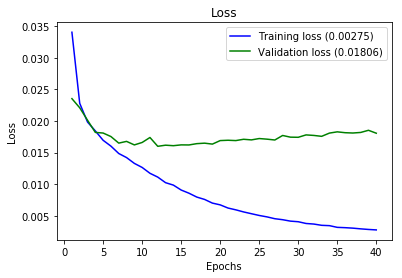

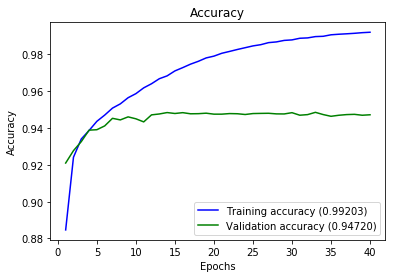

In [10]:
lr_decay = LearningRateScheduler(scheduler)
   

history = model.fit(train_data, train_label,
          batch_size = bs, epochs= EPOCH, 
          verbose=1,validation_split=0.2,callbacks=[lr_decay])

%matplotlib inline
plot_history(history)



In [11]:
test_loss, test_acc = model.evaluate(test_data, test_label,
                                     batch_size=bs)
print('complete stroke test score:', test_loss)
print('complete stroke test accuracy:', test_acc)

test_loss1, test_acc1 = model.evaluate(test_data1, test_label,
                                       batch_size=bs)
print('90% stroke test score:', test_loss1)
print('90% stroke test accuracy:', test_acc1)
test_loss2, test_acc2 = model.evaluate(test_data2, test_label,
                                       batch_size=bs)
print('70% stroke test score:', test_loss2)
print('70% stroke test accuracy:', test_acc2)
test_loss3, test_acc3 = model.evaluate(test_data3, test_label,
                                       batch_size=bs)
print('50% stroke test score:', test_loss3)
print('50% stroke test accuracy:', test_acc3)

126649/126649 [==============================] - 216s 2ms/step
complete stroke test score: 0.01828841735517221
complete stroke test accuracy: 0.9467978428570301
126649/126649 [==============================] - 222s 2ms/step
90% stroke test score: 0.038536957452427294
90% stroke test accuracy: 0.8806149278611651
126649/126649 [==============================] - 254s 2ms/step
70% stroke test score: 0.05407041103981543
70% stroke test accuracy: 0.8352691296309414
126649/126649 [==============================] - 227s 2ms/step
50% stroke test score: 0.09068178903717085
50% stroke test accuracy: 0.7232429786146711


## Plot confusion matrix of test data 

confusion matrix helps expressing the classification results 

From the results shown below, it can be seen that the label 0, which is 'calender' class, has relatively lower predict accuracy compared to other 4 classes. This can be explained from the pie chart above, which is that 'calender' class has less training data than other classes

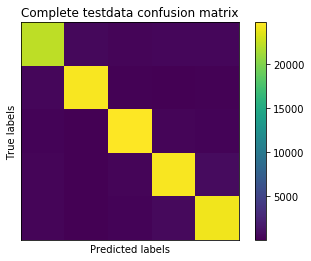

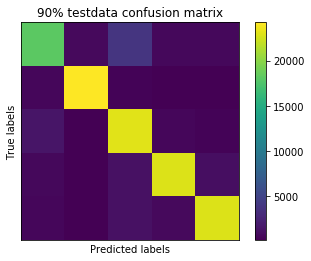

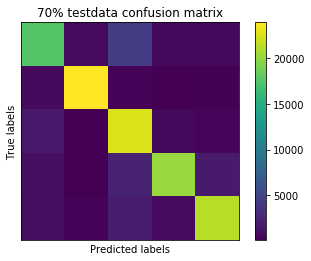

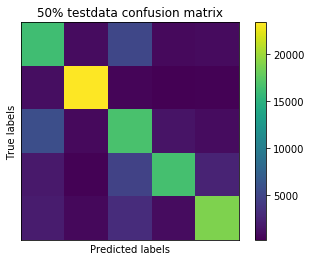

In [12]:
def test_confusion_matrix(test_data,test_Y,title):
    score_pred = model.predict(test_data)
    label_pred = np.argmax(score_pred,1)
    c_m = confusion_matrix(test_Y,label_pred)
    %matplotlib inline
    plt.imshow(c_m)
    plt.xlabel("Predicted labels")
    plt.ylabel("True labels")
    plt.xticks([], [])
    plt.yticks([], [])
    plt.title(title)
    plt.colorbar()
    plt.show()
    return 

test_confusion_matrix(test_data,test_Y,'Complete testdata confusion matrix')
test_confusion_matrix(test_data1,test_Y,'90% testdata confusion matrix')
test_confusion_matrix(test_data2,test_Y,'70% testdata confusion matrix')
test_confusion_matrix(test_data3,test_Y,'50% testdata confusion matrix')




In [14]:
#from keras.models import load_model

model.save('modelall.h5')  # creates a HDF5 file 'my_model.h5'

# returns a compiled model
# identical to the previous one
#model = load_model('model.h5')

